## Super resolution

In [54]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
import tensorflow as tf
from torchvision.models import vgg16_bn
import torchvision.transforms as transforms
from skimage import measure

from  modified_model_fx import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
torch.cuda.set_device(3)

In [21]:
tfms = ([
    RandTransform(tfm=TfmCrop(crop_pad),
                  kwargs={
                      'row_pct': (0, 1),
                      'col_pct': (0, 1),
                      'padding_mode': 'reflection'
                  },
                  p=1.0,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True),
    RandTransform(tfm=TfmPixel(flip_lr),
                  kwargs={},
                  p=0.5,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True),
    RandTransform(tfm=TfmCoord(symmetric_warp),
                  kwargs={'magnitude': (-0.2, 0.2)},
                  p=0.75,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True),
    RandTransform(tfm=TfmLighting(brightness),
                  kwargs={'change': (0.4, 0.6)},
                  p=0.75,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True),
    RandTransform(tfm=TfmLighting(contrast),
                  kwargs={'scale': (0.8, 1.25)},
                  p=0.75,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True)
], [
    RandTransform(tfm=TfmCrop(crop_pad),
                  kwargs={},
                  p=1.0,
                  resolved={},
                  do_run=True,
                  is_random=True,
                  use_on_y=True)
])


### Sizes of images: 

- HR images: **(3, 502, 672)** original (3, 1004, 1344) cut in 4 pieces
- LR images: **(3, 250, 334)** original (3, 500, 669) cut in 4 pieces

In [22]:
path = Path('../../../../../SCRATCH2/marvande/data/train/HR/')

path_lr = path / 'small-250/train'
path_mr = path / 'small-502/train'

path_hr = path / 'HR_patches_train/jpg_images'
path_lr_or = path/'HR_patches_resized/jpg_images'

assert path.exists(), f"need dataset @ {path}"
assert path_hr.exists()

In [23]:
il = ImageList.from_folder(path_hr)
ImageList.from_folder(path_hr)

ImageList (6168 items)
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/HR_patches_train/jpg_images

In [24]:
ImageList.from_folder(path_lr_or)

ImageList (6168 items)
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/HR_patches_resized/jpg_images

In [25]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    #targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(size, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [26]:
# create smaller image sets the first time this nb is run:
sets = [(path_lr, (334,250)), (path_mr, (672,502))]
for p, size in sets:
    if not p.exists():
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)


In [27]:
ImageList.from_folder(path_lr)

ImageList (6168 items)
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train

In [28]:
ImageList.from_folder(path_mr)

ImageList (6168 items)
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-502/train

Creates two set of images from the HR images:
- HR: (3, 502, 672)
- LR: (3, 250, 334)
- MR: (3, 502, 672)

Create training data:

In [29]:
# set image size and batch size to which data is transformed:
bs, size = 15, (250, 334)
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

Data without size and other transformations:


ImageDataBunch;

Train: LabelList (5552 items)
x: ImageImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
y: ImageList
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train;

Valid: LabelList (616 items)
x: ImageImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
y: ImageList
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train;

Test: None
LR (left) vs HR (right) data


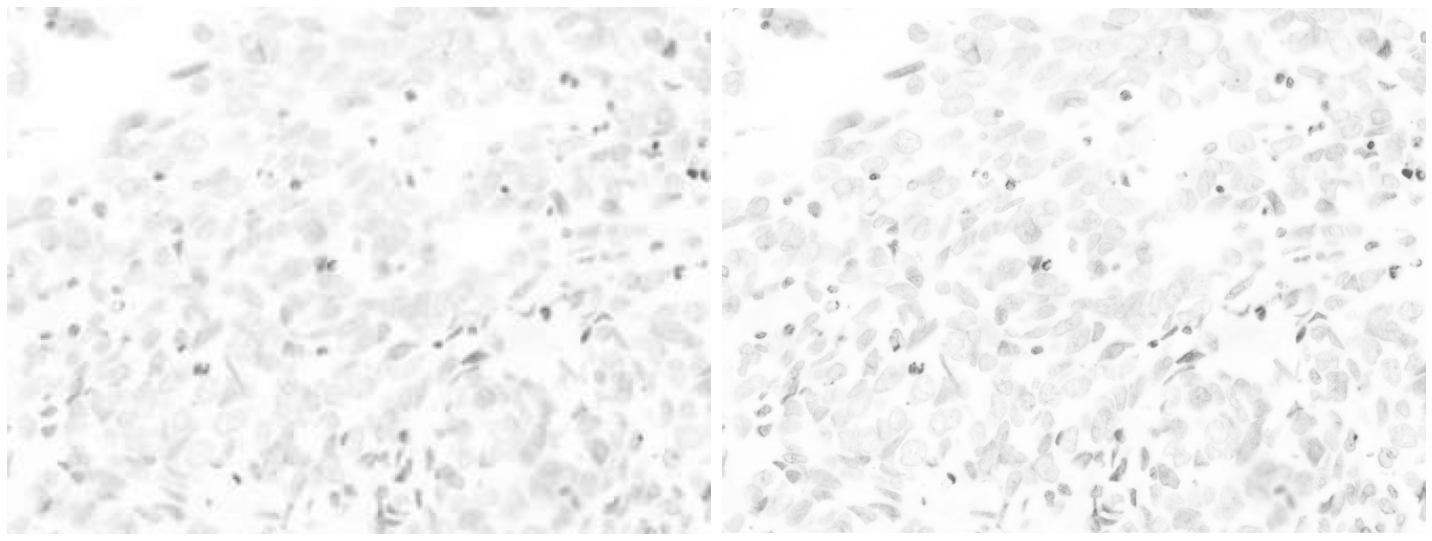

In [30]:
data = (src.label_from_func(lambda x: path_hr / x.relative_to(path_lr)).databunch())
print(data)
print('LR (left) vs HR (right) data')
data.show_batch(rows=1, figsize=(20,20))

With transformations, resized HR image to the same size as LR

ImageDataBunch;

Train: LabelList (5552 items)
x: ImageImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
y: ImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train;

Valid: LabelList (616 items)
x: ImageImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
y: ImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train;

Test: None
LR (left) vs HR (right) data


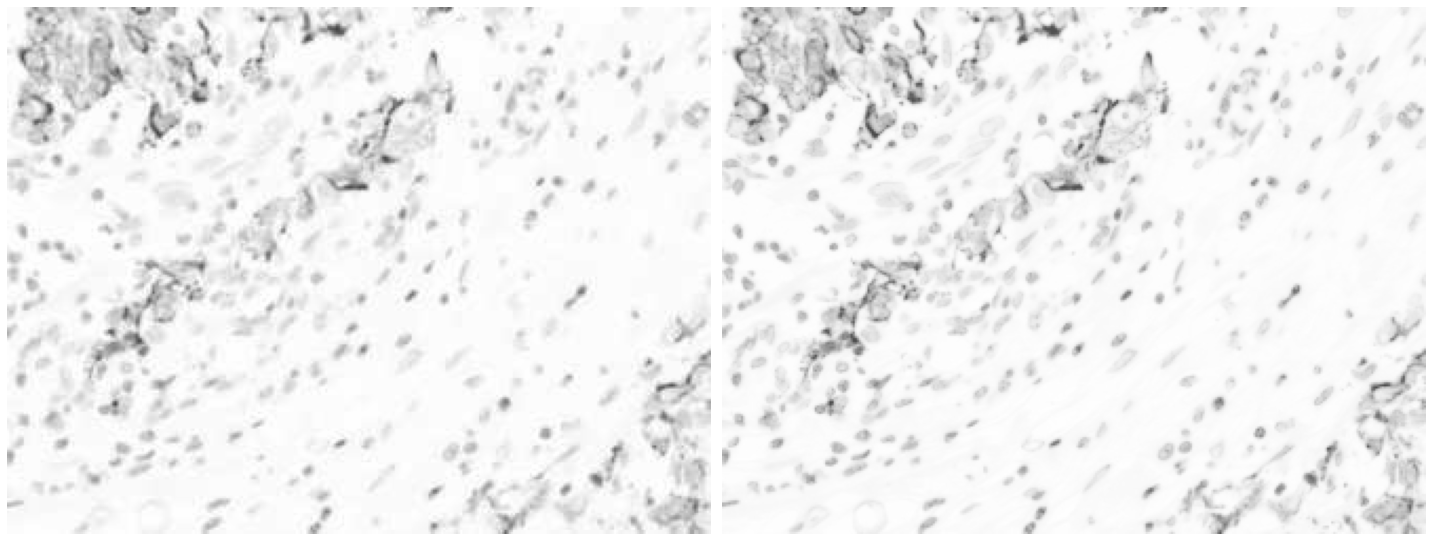

In [31]:
# With transformations, resized HR image to the same size as LR
data = (src.label_from_func(lambda x: path_hr/x.relative_to(path_lr)).transform(tfms, size=size, tfm_y=True)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
data.c = 3
print(data)
print('LR (left) vs HR (right) data')
data.show_batch(rows=1, figsize=(20,20))

Function that does both and creates training and validation data: 

In [32]:
def get_data(bs, size):
    #label_from_func: apply func to every input to get its label.
    # defining a custom function to extract the labels 
    data = src.label_from_func(lambda x: path_hr / x.relative_to(path_lr))
    
    #apply any data transformations, 
    #i.e. data augmentation techniques to help avoid overfitting during training
    data = data.transform(
            tfms, size=size,
            tfm_y=True).databunch(bs=bs).normalize(imagenet_stats, do_y=True)
    data.c = 3
    return data

Create training data of the shape (3, 250, 334):

In [33]:
data = get_data(bs,size)
data

ImageDataBunch;

Train: LabelList (5552 items)
x: ImageImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
y: ImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train;

Valid: LabelList (616 items)
x: ImageImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
y: ImageList
Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334),Image (3, 250, 334)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train;

Test: None

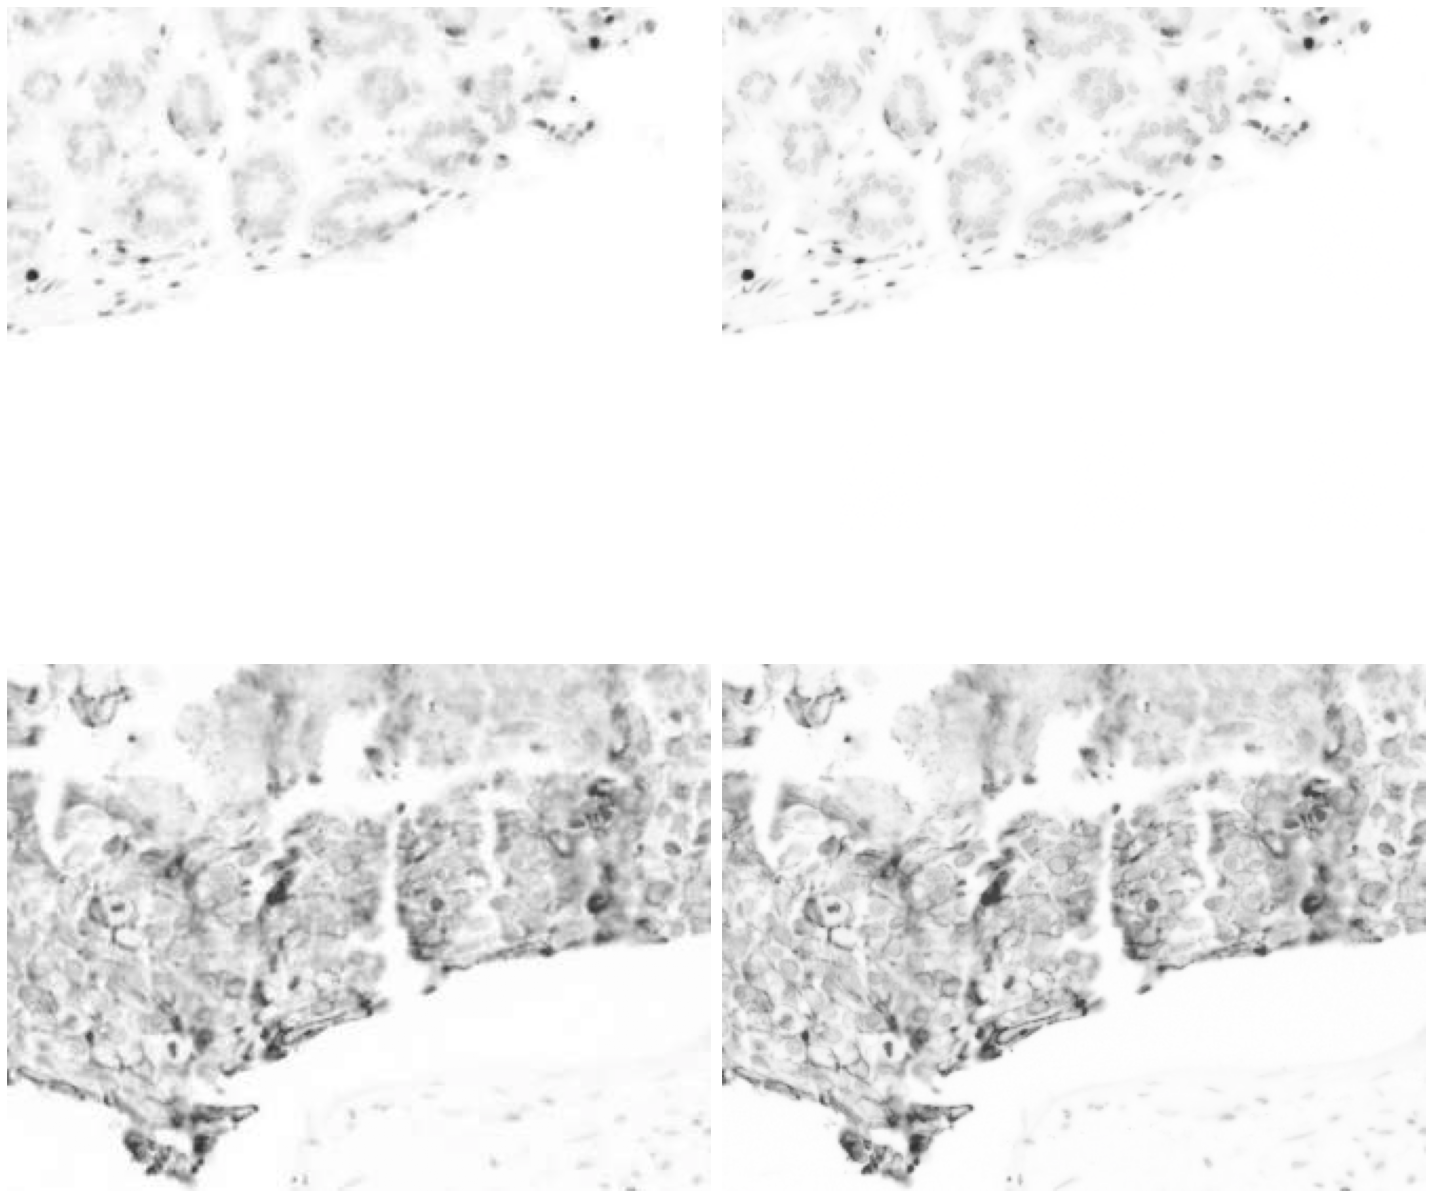

In [34]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(20,20))

## Feature loss

In [35]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [36]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [37]:
gram_matrix(t)

tensor([[[0.3176, 0.3176, 0.3176],
         [0.3176, 0.3176, 0.3176],
         [0.3176, 0.3176, 0.3176]],

        [[0.3176, 0.3176, 0.3176],
         [0.3176, 0.3176, 0.3176],
         [0.3176, 0.3176, 0.3176]]])

In [38]:
base_loss = F.l1_loss

In [39]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [40]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [41]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        #feat losses
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        #gram: 
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [42]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [26]:
#lr = 1e-3
lr = 1e-3
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=10)

In [51]:
# delete all tensors and free cache:
for obj in gc.get_objects():
    if torch.is_tensor(obj):
        del obj
torch.cuda.empty_cache()
gc.collect()
#learn.destroy()

#get free memory (in MBs) for the currently selected gpu id, after emptying the cache
print(
    'free memory (in MBs) for the currently selected gpu id, after emptying the cache: ',
    gpu_mem_get_free_no_cache())

print(
    'used memory (in MBs) for the currently selected gpu id, after emptying the cache:',
    gpu_mem_get_used_no_cache())

gpu_mem_get_all()

free memory (in MBs) for the currently selected gpu id, after emptying the cache:  11629
used memory (in MBs) for the currently selected gpu id, after emptying the cache: 583


[GPUMemory(total=12212, free=6920, used=5292),
 GPUMemory(total=12196, free=7717, used=4478),
 GPUMemory(total=12196, free=7183, used=5012),
 GPUMemory(total=12212, free=11629, used=583)]

In [52]:
wd = 1e-3
learn = unet_learner(data,
                     arch,
                     wd=wd,
                     loss_func=feat_loss,
                     callback_fns=LossMetrics,
                     blur=True,
                     norm_type=NormType.Weight)
# garbage collection:
gc.collect()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


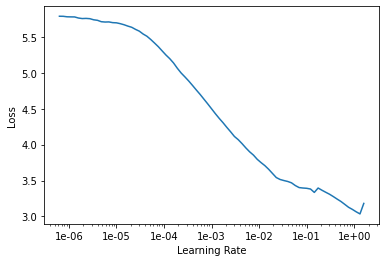

In [53]:
learn.lr_find()
learn.recorder.plot()

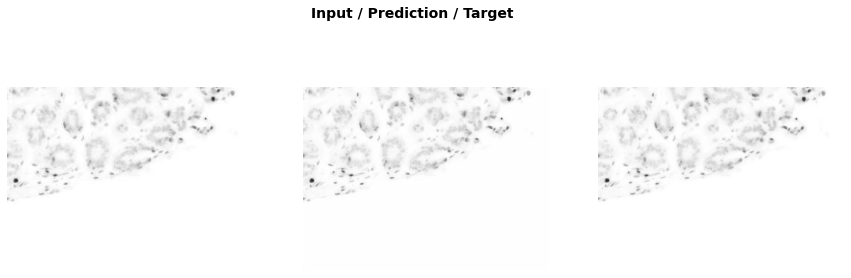

In [55]:
do_fit('1a_mod', slice(lr*10))

In [57]:
learn.unfreeze()

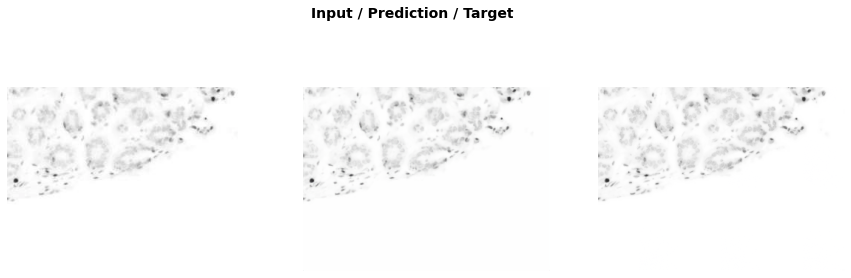

In [58]:
do_fit('1b_mod', slice(1e-5,lr))

Phase 2: 

In [27]:
torch.cuda.empty_cache()
gc.collect()
#learn.destroy()

#get free memory (in MBs) for the currently selected gpu id, after emptying the cache
print(
    'free memory (in MBs) for the currently selected gpu id, after emptying the cache: ',
    gpu_mem_get_free_no_cache())

print(
    'used memory (in MBs) for the currently selected gpu id, after emptying the cache:',
    gpu_mem_get_used_no_cache())

gpu_mem_get_all()

free memory (in MBs) for the currently selected gpu id, after emptying the cache:  10880
used memory (in MBs) for the currently selected gpu id, after emptying the cache: 1332


[GPUMemory(total=12212, free=9840, used=2372),
 GPUMemory(total=12196, free=7717, used=4478),
 GPUMemory(total=12196, free=10534, used=1661),
 GPUMemory(total=12212, free=10880, used=1332)]

In [28]:
new_size = (502, 672)
bs = 4
data = get_data(bs,new_size)

wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)

lr = 1e-3
# garbage collection: 
gc.collect();

In [29]:
learn.data = data
learn.freeze()
gc.collect()

20

In [30]:
data

ImageDataBunch;

Train: LabelList (5552 items)
x: ImageImageList
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
y: ImageList
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train;

Valid: LabelList (616 items)
x: ImageImageList
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
y: ImageList
Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672),Image (3, 502, 672)
Path: ../../../../../SCRATCH2/marvande/data/train/HR/small-250/train;

Test: None

In [31]:
learn.load('1b_mod');

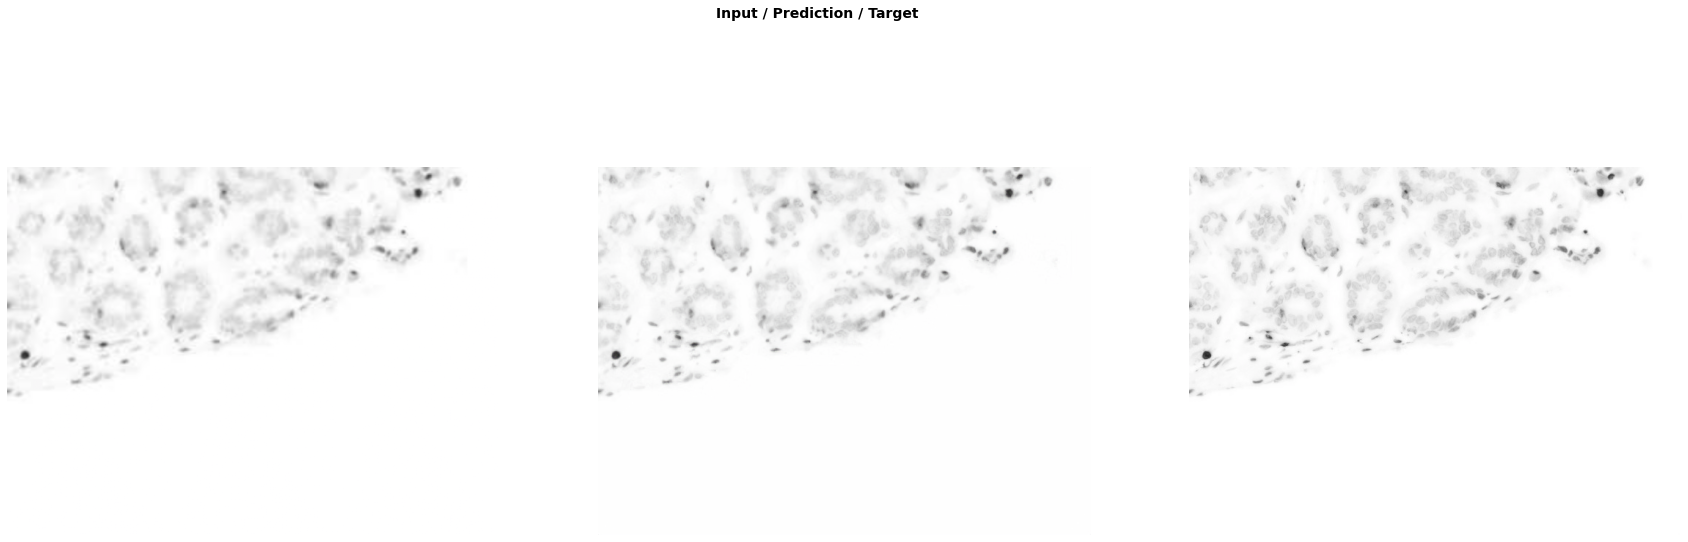

In [32]:
do_fit('2a_mod')

In [33]:
learn.unfreeze()

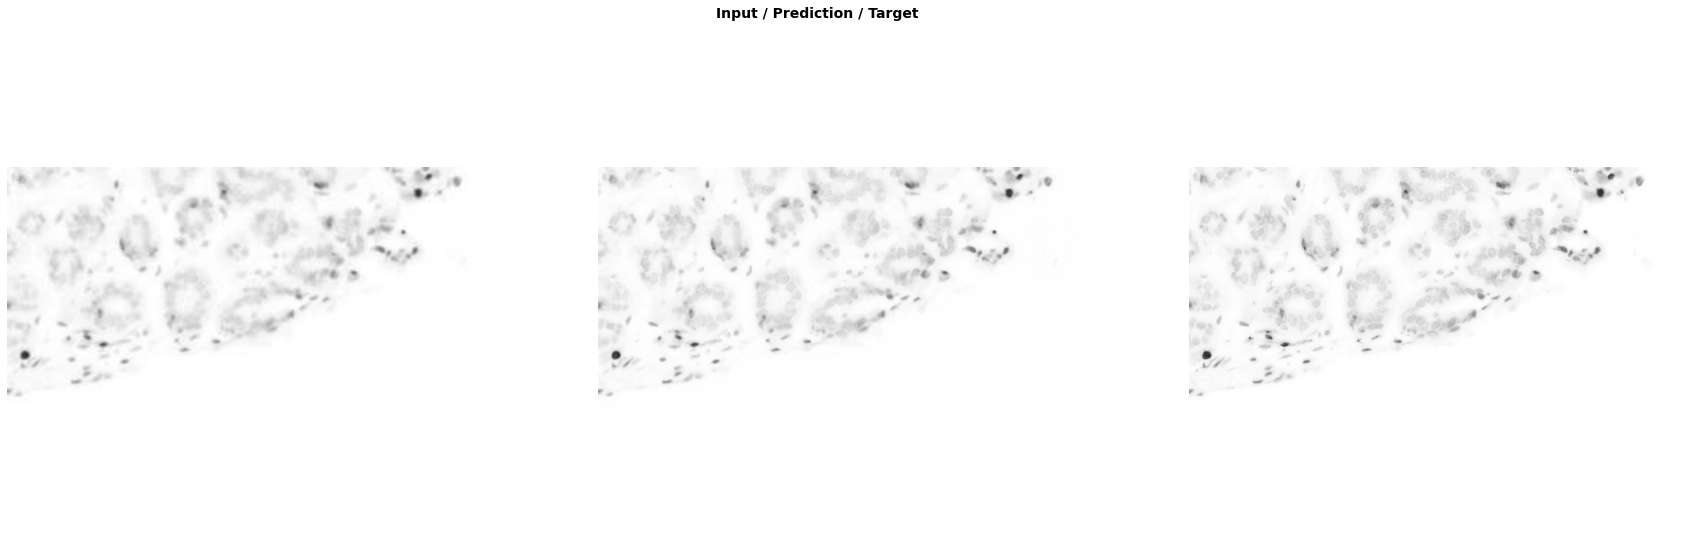

In [34]:
do_fit('2b_mod', slice(1e-6,1e-4), pct_start=0.3)

## Testing : 

Reconstruct the learn object, this time with l1_loss and not with feature_loss, **why?** 

In [43]:
learn = None
gc.collect()
learn = unet_learner(data,
                     arch,
                     loss_func=F.l1_loss,
                     blur=True,
                     norm_type=NormType.Weight)

##### Prediction:

Set the sizes of the LR input images (`size_lr`) for testing and the HR images (`size_mr`).

In [44]:
size_mr = (3, 502, 672)
size_lr = (3, 250, 334)

#Check free GPU RAM:
free = gpu_mem_get_free_no_cache()
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(250, 334), have 10770MB of GPU RAM free


Create testing data, `data_mr` of size HR and `data_lr` of size LR:

In [45]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(tfms, size=size_mr, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3
data_lr = (ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(tfms, size=size_lr, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_lr.c = 3

Load the learn object from the last phase (`2b_mod`) and set it's data to `data_mr` (**why?**).

In [46]:
learn.load('2b_mod')
learn.data = data_mr

Select the images we are going to use for testing from `data_mr` and `data_lr`: 

In [47]:
# Ground truth HR image:
gt_HR = data_mr.valid_ds.y.items[1]

# LR version of the same image:
lr = data_lr.valid_ds.x.items[1]

To be able to apply the model and predict the HR image from the LR, we need to resample the LR image to be of the same size as the HR, as the model inputs and outputs images of the same size. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


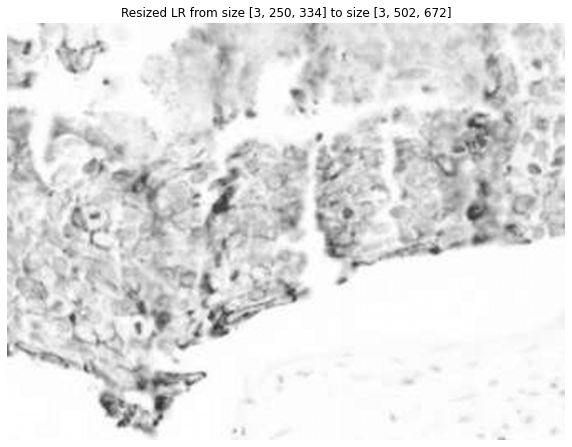

In [48]:
lr_data = open_image(lr)

# resample to same size as HR:
# for pytorch, have to add a first new dimension to indicate bs = 1
# now lr_data of shape [1, 3, 250, 334]
lr_data = lr_data.data.unsqueeze(0)
lr_resized = torch.nn.functional.interpolate(lr_data, size_mr[1:],
                                             mode='bicubic')
# remove the previous added dimension
lr_resized = lr_resized.squeeze()

# plot resized LR: 
plot_single_image(lr_resized, 
                  'Resized LR from size {} to size {}'\
                  .format(list(lr_data.squeeze().shape), 
                          list(lr_resized.shape)), (10,10))

Now that we have resized the LR to the same size as the ground truth HR, we can feed it to the model and predict a new HR image.

In [49]:
# Ground truth HR: 
im_HR_gt = open_image(gt_HR)
#print('HR ground thruth shape: {}'.format(list(im_HR_gt.shape)))

# Prediction of model: 
p, img_pred, b = learn.predict(Image(lr_resized))
#print('Reconstructed HR shape: {}'.format(list(p.shape)))

# Assert reconstructed HR has same shape as ground truth HR:
assert(list(p.shape) == list(im_HR_gt.shape))

##### Visualisation:

Compare this predicted image to the ground truth HR and LR: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


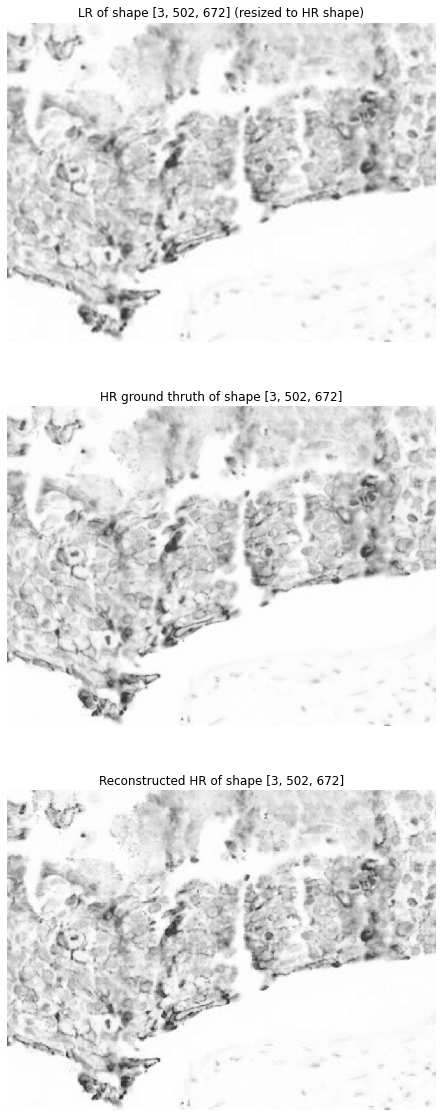

In [50]:
plot_3_images(lr_resized, im_HR_gt, img_pred, (20,20))

##### Evaluate loss and error metrics:

In [51]:
trans1 = transforms.ToTensor()
trans = transforms.ToPILImage()

Predicted HR (left) VS original HR (right)
MSE: 0.00068984, NMSE: 0.02960925, SSIMS for each channel: 0.9395, 0.9329, 0.9420


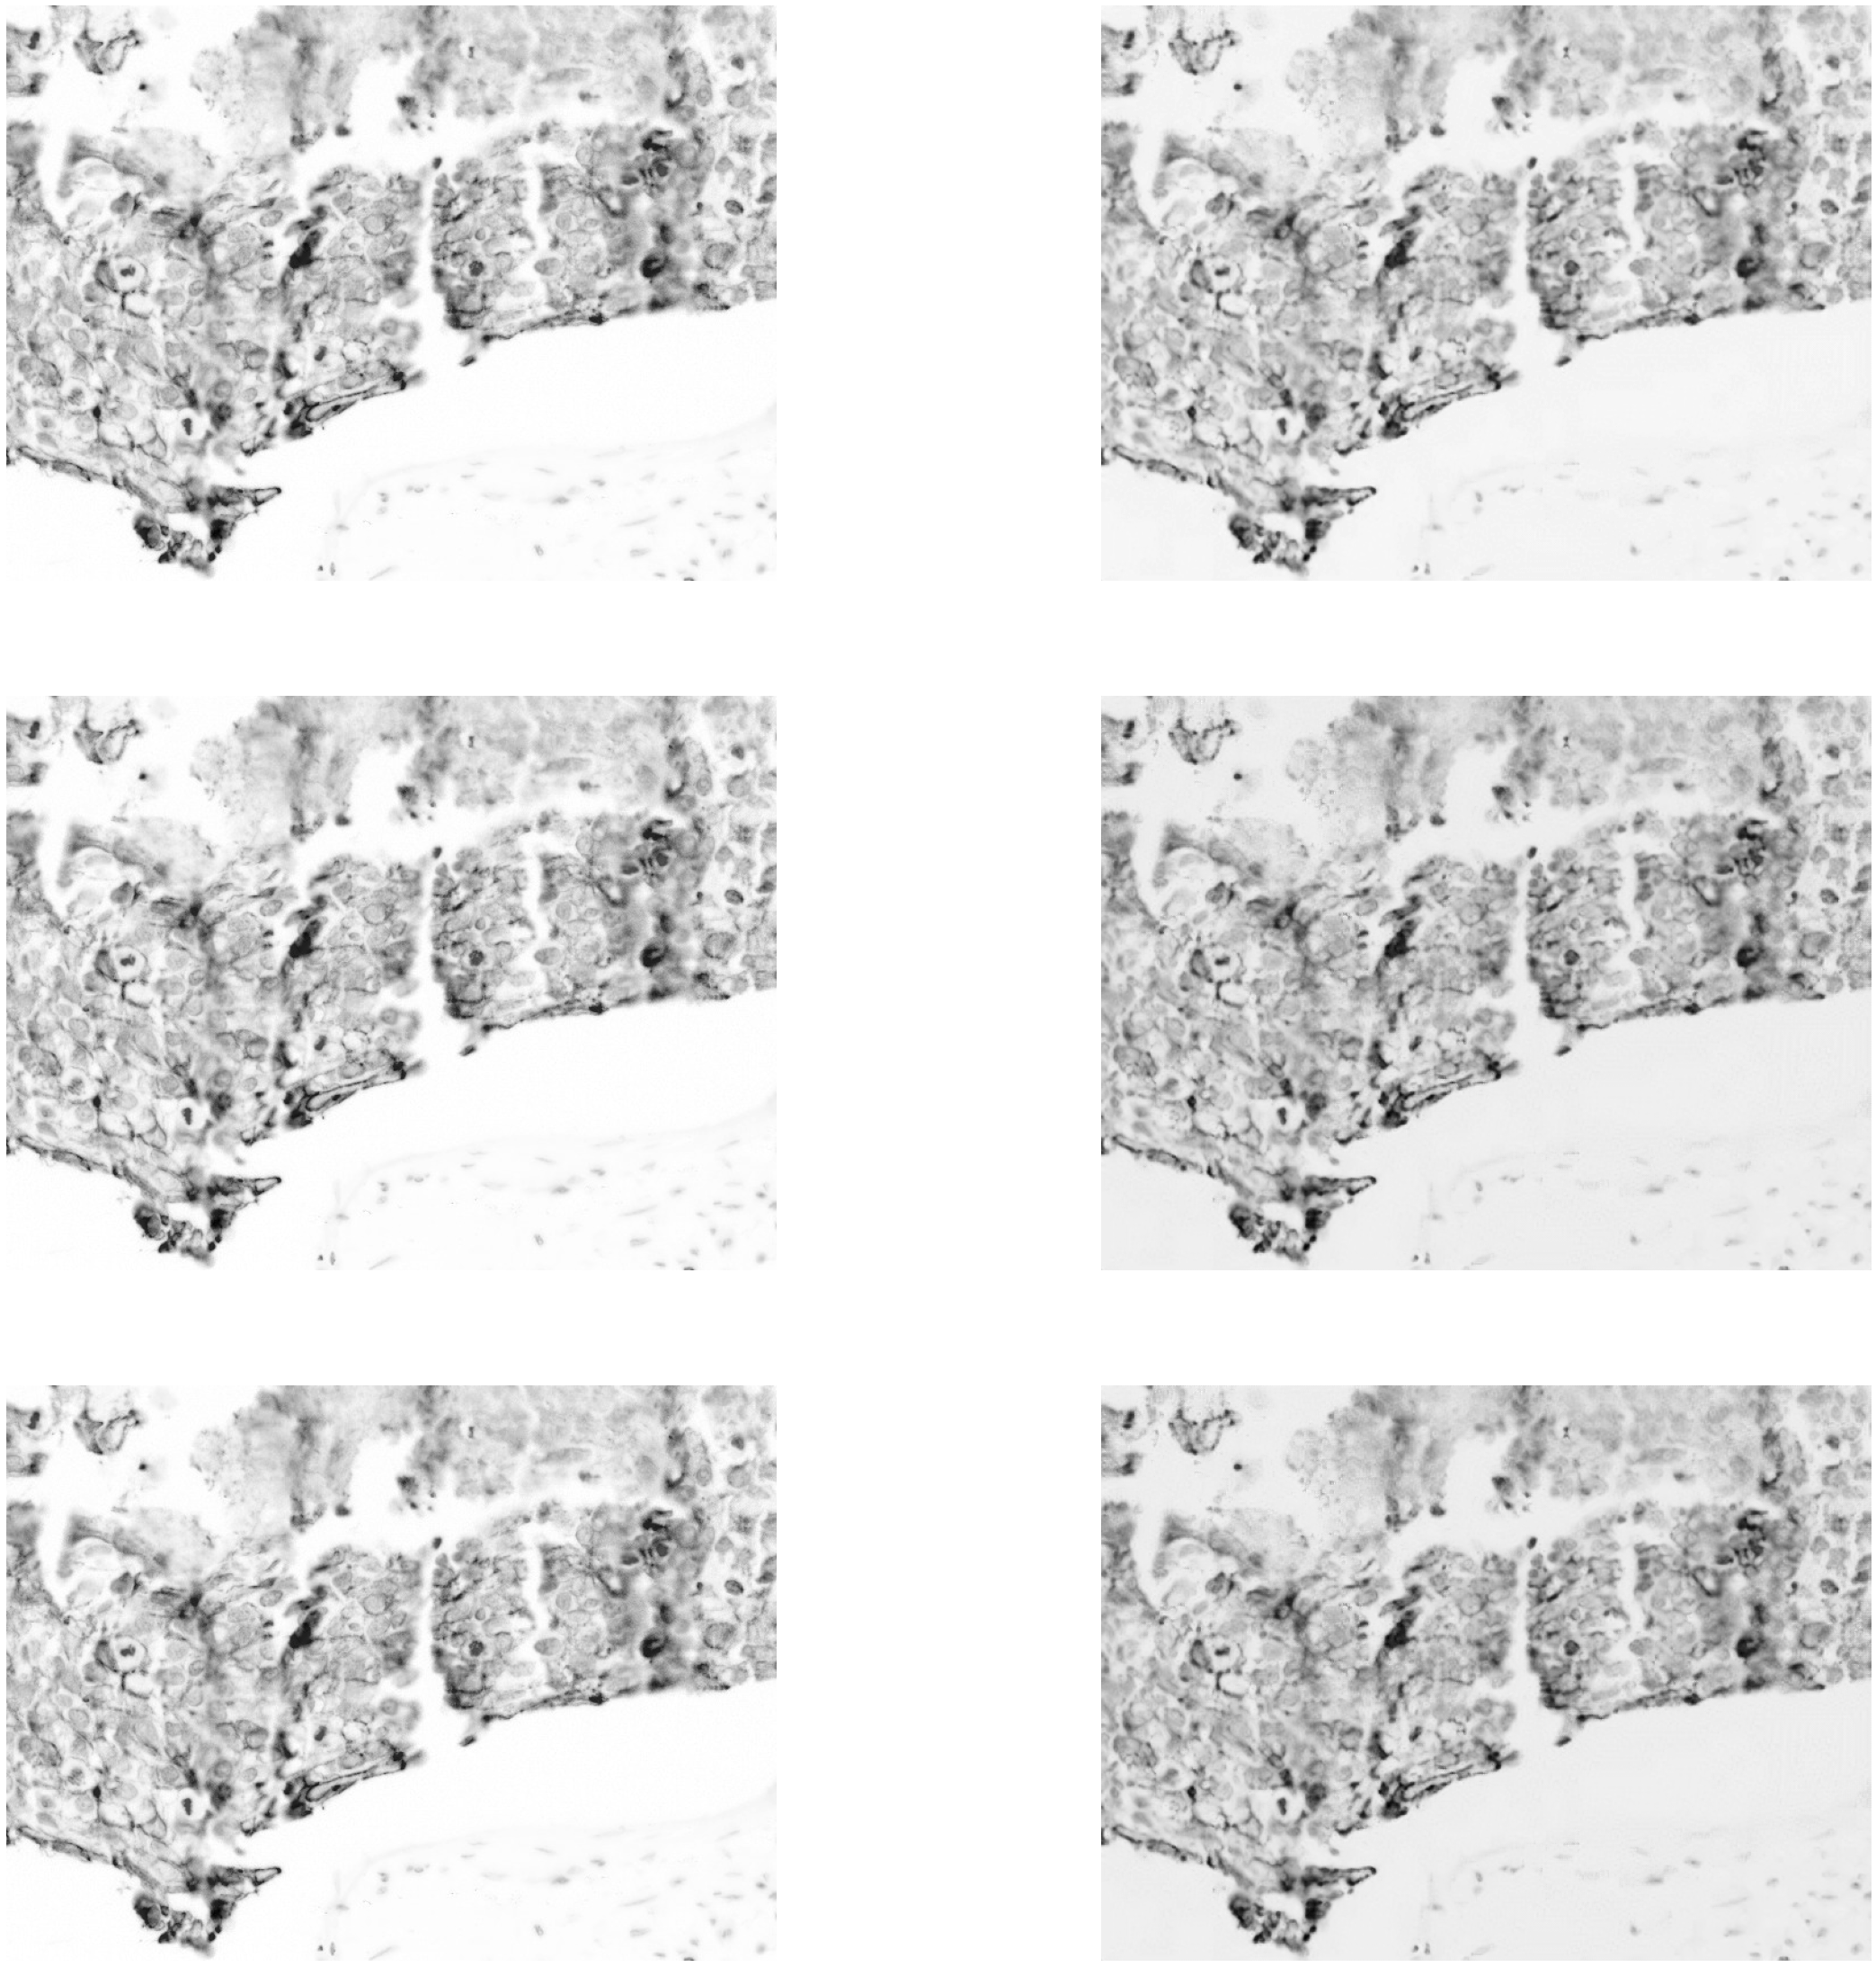

In [53]:
compare_images_metrics(trans1(trans(im_HR_gt.data)).numpy(), img_pred.numpy())